# 자연어 기반 카드 매칭 챗봇 서비스

카드고릴라 사이트의 모든 카드 정보를 크롤링해서
사용자가 자연어로 요청사항을 입력하면 요청사항에 맞는
카드 혜택을 찾아 최적의 카드를 추천해주는 카드매칭 서비스입니다.

## 목차

- 데이터 크롤링 및 전처리
    - 크롤링
    - 데이터 Chunking
    - 혜택 정형화

- 1차 구현: Baseline RAG 시스템
    - OpenAI 범용 임베딩 모델 사용

- 2차 구현: 도메인 특화 RAG 시스템
    - 임베딩 모델 파인튜닝: Gemma-300m 기반 Triplet 데이터셋 구축 및 훈련
    - 벡터 저장소: ChromaDB 구축 및 코사인 유사도 기반 의미적 거리 측정
    - 커스텀 리트리버 설계: 다중 의도 추출 및 파이썬 Set 연산을 활용한 AND 로직 구현

-  평가 및 결론

# 카드고릴라 사이트의 모든 카드정보(신용카드/체크카드) 크롤링

1. 카드고릴라 api를 호출하여 1,518개의 카드 idx 수집

2. 수집된 idx 기반으로 상세페이지 링크 생성 후, BeautifulSoup을 활용해 혜택 데이터를 파싱.

3. 카드 1장을 하나의 문서로 저장하지 않고, 포함된 혜택 카테고리별로 객체를 분리하여 저장.
    - 이유: 카드 한 장에 섞인 여러 혜택(교통, 편의점, 영화 등)이 벡터 공간에서 서로 간섭하여 검색 정확도를 떨어뜨리는 현상 방지.



In [ ]:
import requests
import json
import time
from bs4 import BeautifulSoup

# 1. API 통신을 위한 헤더 설정 (브라우저 정상 접속 모사)
headers = {
    "authority": "api.card-gorilla.com:8080",
    "accept": "application/json, text/plain, */*",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36",
    "referer": "https://www.card-gorilla.com/"
}

def get_rag_merged_data(card_data):
    """
    [Chunking]
    카드 1장의 데이터를 받아서 혜택 카테고리별로 분리하여 7,757개의 혜택 조각을 생성
    """
    card_idx = card_data.get("idx")
    card_name = card_data.get("name")
    corp_name = card_data.get("corp_txt")
    
    # 상세 페이지 API 호출
    detail_url = f"https://api.card-gorilla.com:8080/v1/cards/{card_idx}"
    try:
        res = requests.get(detail_url, headers=headers, timeout=10)
        res_data = res.json()
        
        key_benefits = res_data.get('key_benefit', [])
        merged_benefits = {}
        
        # [데이터 정제] HTML 태그 제거 및 카테고리별 그룹화
        for kb in key_benefits:
            category = kb.get('title') # 예: '교통', '푸드', '통신'
            html_content = kb.get('info', '')
            
            if html_content:
                # BeautifulSoup을 활용해 불필요한 HTML 태그를 걷어내고 순수 텍스트만 추출
                soup = BeautifulSoup(html_content, 'html.parser')
                clean_text = soup.get_text(separator=" ", strip=True)
                
                if category not in merged_benefits:
                    merged_benefits[category] = []
                
                # 중복 텍스트 방지 로직
                if clean_text not in merged_benefits[category]:
                    merged_benefits[category].append(clean_text)
        
        results = []
        # [데이터 파편화] 1개의 카드 객체를 여러 개의 혜택 단위 객체로 분리 (1:N 매핑)
        # 이 과정에서 1,518개의 카드가 7,757개의 검색 단위(Chunk)로 확장됨
        for category, texts in merged_benefits.items():
            combined_text = " / ".join(texts)
            # LLM이 문맥을 파악하기 좋도록 '카드명 + 카테고리 + 상세설명'을 하나의 문장으로 구성
            full_content = f"[{card_name}] {category} 혜택: {combined_text}"
            
            results.append({
                "content": full_content, # ChromaDB 임베딩 및 유사도 검색 대상
                "metadata": {            # 검색 후 2차 필터링(카드사, 연회비 등)을 위한 메타데이터
                    "card_id": card_idx,
                    "card_name": card_name,
                    "corp": corp_name,
                    "category": category,
                    "min_performance": card_data.get("pre_month_money"),
                    "annual_fee": card_data.get("annual_fee_basic")
                }
            })
        return results
    except Exception as e:
        print(f"   ⚠️ Error (ID {card_idx}): {e}")
        return []

# --- 2. 전체 카드 전수 수집 프로세스 ---
all_rag_data = []
all_card_indices = []
page = 1

print("🚀 모든 카드의 데이터 수집을 시작합니다. (전체 페이지 순회)")

while True:
    # 페이지네이션을 통한 전수 조사 (한 페이지당 20개씩 호출)
    list_url = f"https://api.card-gorilla.com:8080/v1/cards?p={page}&perPage=20&cate=CRD"
    try:
        response = requests.get(list_url, headers=headers, timeout=10)
        data = response.json()
        goods_list = data.get("data", [])

        # 탈출 조건: 더 이상 수집할 카드가 없으면 종료
        if not goods_list:
            print(f"\n✅ 수집을 완료했습니다. (마지막 페이지: {page-1})")
            break

        print(f"\n📄 현재 {page}페이지 수집 중... (현재 누적 데이터: {len(all_rag_data)}개)")

        for card in goods_list:
            c_name = card.get('name')
            c_idx = card.get('idx')
            
            all_card_indices.append(c_idx)
            
            # [실행] 각 카드별 상세 혜택 수집 및 파편화 작업 호출
            benefit_units = get_rag_merged_data(card)
            all_rag_data.extend(benefit_units)
            
            # [서버 매너] API 과부하 및 차단 방지를 위한 딜레이 설정
            time.sleep(0.4)

        page += 1 

    except Exception as e:
        print(f"❌ {page}페이지 호출 중 오류 발생: {e}")
        break

# --- 3. RAG 최적화 데이터 저장 ---

# 벡터 DB(ChromaDB)에 임베딩할 최종 마스터 데이터셋 저장
with open("all_card_benefits_rag.json", "w", encoding="utf-8") as f:
    json.dump(all_rag_data, f, ensure_ascii=False, indent=4)

# 유효성 검증을 위한 인덱스 리스트 별도 저장
with open("all_card_idx_list.json", "w", encoding="utf-8") as f:
    json.dump(all_card_indices, f, ensure_ascii=False, indent=4)

print("\n" + "="*50)
print(f"✨ 최종 수집 완료!")
print(f"📂 원본 카드 수: {len(all_card_indices)}개")
print(f"📂 파편화된 혜택 데이터(Chunk): {len(all_rag_data)}개") # 1,500 -> 7,757 확장 결과
print("="*50)

# 카테고리 분류 main, sub

수집된 원본 데이터의 카테고리는 카드사마다 명칭이 달라 매우 파편화되어 있습니다. 이를 통합 매핑 사전을 통해 대분류 체계로 재구성하여 RAG 모델의 검색 효율성을 극대화합니다.


검색 고도화: 사용자가 "쇼핑"이라고 검색했을 때 '마트', '백화점', '온라인쇼핑' 등 유사 카테고리를 한 번에 조회할 수 있습니다.

필터링 성능 향상: 벡터 유사도 검색 전, 대분류(main_category)를 활용한 메타데이터 필터링을 적용하여 관련 없는 검색 결과를 사전에 차단합니다.

In [1]:
import json

# 데이터 로드
with open('./data/all_credit_benefits_rag.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# 카테고리 종류 수집
all_categories = sorted(list(set(item['metadata']['category'] for item in raw_data)))

print(f"📊 현재 발견된 카테고리 총 {len(all_categories)}개:")
print(all_categories)

📊 현재 발견된 카테고리 총 127개:
['APP', 'BC TOP', 'CJ ONE', 'KT', 'LGU+', 'OK캐쉬백', 'OTT/영화/문화', 'PP', 'SKT', 'SPA브랜드', 'SSM', '간편결제', '게임', '경기관람', '고속버스', '골프', '공과금', '공과금/렌탈', '공연/전시', '공항', '공항라운지', '공항라운지/PP', '교육/육아', '교통', '국내외가맹점', '국민행복', '금융', '기차', '기타', '네이버페이', '대중교통', '대한항공', '대형마트', '도서', '동물병원', '드럭스토어', '디지털구독', '라운지키', '레저/스포츠', '렌탈 ', '렌터카', '리조트', '마트/편의점', '멤버십포인트', '면세점', '모든가맹점', '무실적', '무이자할부', '문화센터', '바우처', '배달앱', '백화점', '베이커리', '병원', '병원/약국', '보험', '보험사', '뷰티/피트니스', '비즈니스', '삼성페이', '생활', '선택형', '소셜커머스', '쇼핑', '수수료우대', '아시아나항공', '아울렛', '애완동물', '약국', '어린이집', '여행/숙박', '여행사', '연회비지원', '영화', '온라인 여행사', '온라인쇼핑', '유의사항', '은행사', '음원사이트', '인테리어', '일반음식점', '자동차', '자동차/하이패스', '저가항공', '저녁', '적립', '전통시장', '점심', '정비', '제주항공', '제휴/PLCC', '주유', '주유소', '지역', '진에어', '충전소', '카드사', '카카오페이', '카페', '카페/디저트', '캐시백', '택시', '테마파크', '통신', '패밀리레스토랑', '패스트푸드', '편의점', '푸드', '프리미엄', '프리미엄 서비스', '피트니스', '하이브리드', '하이패스', '학습지', '학원', '할인', '항공권', '항공마일리지', '해외', '해외이용', '해외직구', '해피포인트', '헤어', '혜택 프로모

In [ ]:
import json
import os

# 1. 신용/체크카드 전체 카테고리를 커버하는 통합 매핑 사전 (보강됨)
category_mapping = {
    # 쇼핑/생활 (마트, 편의점, 온라인, 드럭스토어 등)
    '쇼핑': '쇼핑/생활', '대형마트': '쇼핑/생활', '온라인쇼핑': '쇼핑/생활', '백화점': '쇼핑/생활', '소셜커머스': '쇼핑/생활', 
    '홈쇼핑': '쇼핑/생활', '아울렛': '쇼핑/생활', 'SPA브랜드': '쇼핑/생활', 'SSM': '쇼핑/생활', '전통시장': '쇼핑/생활', 
    '마트/편의점': '쇼핑/생활', '편의점': '쇼핑/생활', '드럭스토어': '쇼핑/생활', '화장품': '쇼핑/생활', '인테리어': '쇼핑/생활',
    '생활': '쇼핑/생활', '배달앱': '쇼핑/생활',
    
    # 푸드/카페 (음식점, 카페, 아이스크림 등)
    '카페': '푸드/카페', '카페/디저트': '푸드/카페', '베이커리': '푸드/카페', '일반음식점': '푸드/카페', 
    '패스트푸드': '푸드/카페', '패밀리레스토랑': '푸드/카페', '점심': '푸드/카페', '저녁': '푸드/카페', '푸드': '푸드/카페',
    '아이스크림': '푸드/카페',
    
    # 교통/자동차
    '주유': '교통/자동차', '주유소': '교통/자동차', '충전소': '교통/자동차', '택시': '교통/자동차', '하이패스': '교통/자동차', 
    '자동차': '교통/자동차', '자동차/하이패스': '교통/자동차', '정비': '교통/자동차', '교통': '교통/자동차', 
    '대중교통': '교통/자동차', '고속버스': '교통/자동차', '기차': '교통/자동차', '하이브리드': '교통/자동차', '렌터카': '교통/자동차',
    
    # 여행/프리미엄 (항공, 호텔, 라운지 등)
    '여행/숙박': '여행/프리미엄', '호텔': '여행/프리미엄', '리조트': '여행/프리미엄', '항공권': '여행/프리미엄', '대한항공': '여행/프리미엄', 
    '아시아나항공': '여행/프리미엄', '저가항공': '여행/프리미엄', '제주항공': '여행/프리미엄', '진에어': '여행/프리미엄', '여행사': '여행/프리미엄', 
    '온라인 여행사': '여행/프리미엄', '해외': '여행/프리미엄', '해외이용': '여행/프리미엄', '해외직구': '여행/프리미엄', '공항': '여행/프리미엄', 
    '항공마일리지': '여행/프리미엄', 'PP': '여행/프리미엄', '공항라운지': '여행/프리미엄', '공항라운지/PP': '여행/프리미엄', 
    '라운지키': '여행/프리미엄', '프리미엄': '여행/프리미엄', '프리미엄 서비스': '여행/프리미엄', '바우처': '여행/프리미엄', '비즈니스': '여행/프리미엄', '면세점': '여행/프리미엄',
    
    # 디지털/통신/구독
    '통신': '디지털/통신', 'SKT': '디지털/통신', 'KT': '디지털/통신', 'LGU+': '디지털/통신', '디지털구독': '디지털/통신', 
    'OTT/영화/문화': '디지털/통신', '음원사이트': '디지털/통신', '게임': '디지털/통신', '네이버페이': '디지털/통신', 
    '삼성페이': '디지털/통신', '카카오페이': '디지털/통신', '간편결제': '디지털/통신', 'APP': '디지털/통신',
    
    # 교육/의료/육아 (체크카드 전용 카테고리 추가)
    '학원': '교육/의료/육아', '학습지': '교육/의료/육아', '교육/육아': '교육/의료/육아', '어린이집': '교육/의료/육아', '도서': '교육/의료/육아', 
    '병원': '교육/의료/육아', '약국': '교육/의료/육아', '병원/약국': '교육/의료/육아', '문화센터': '교육/의료/육아', '동물병원': '교육/의료/육아', 
    '애완동물': '교육/의료/육아', '국민행복': '교육/의료/육아', '아이행복': '교육/의료/육아', '유치원': '교육/의료/육아',
    
    # 금융/납부 (공과금, 보험, 증권 등)
    '공과금': '금융/납부', '공과금/렌탈': '금융/납부', '보험': '금융/납부', '보험사': '금융/납부', '금융': '금융/납부', 
    '은행사': '금융/납부', '수수료우대': '금융/납부', '렌탈': '금융/납부', '카드사': '금융/납부', '증권사': '금융/납부',
    
    # 문화/레저/스포츠
    '영화': '문화/레저', '테마파크': '문화/레저', '레저/스포츠': '문화/레저', '골프': '문화/레저', '경기관람': '문화/레저', 
    '공연/전시': '문화/레저', '피트니스': '문화/레저', '뷰티/피트니스': '문화/레저', '헤어': '문화/레저',
    
    # 기본/전가맹점 (적립, 할인, 실적 상관없는 혜택 등)
    '모든가맹점': '기본/전가맹점', '국내외가맹점': '기본/전가맹점', '무실적': '기본/전가맹점', '무이자할부': '기본/전가맹점', 
    '할인': '기본/전가맹점', '적립': '기본/전가맹점', '캐시백': '기본/전가맹점', '연회비지원': '기본/전가맹점', '선택형': '기본/전가맹점', '직장인': '기본/전가맹점',
    
    # 포인트/제휴 (특정 제휴사 멤버십)
    '멤버십포인트': '포인트/제휴', '해피포인트': '포인트/전유', 'OK캐쉬백': '포인트/제휴', 'CJ ONE': '포인트/제휴', 'BC TOP': '포인트/제휴', '제휴/PLCC': '포인트/제휴'
}

def process_card_file(file_path, output_path):
    # 파일 존재 여부 확인
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 데이터 로드
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 데이터 변환 실행
    for item in data:
        # 1. 카테고리 추출 및 공백 제거
        old_cat = item['metadata'].get('category', '기타').strip()
        
        # 2. 매핑 테이블에서 찾고, 없으면 '기타/안내'로 통합
        new_cat = category_mapping.get(old_cat, '기타/안내')
        
        # 3. 데이터 업데이트 (main_category 필드 추가)
        item['metadata']['main_category'] = new_cat
        item['metadata']['sub_category'] = old_cat

    # 저장
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

    # 결과 요약
    final_cats = set(item['metadata']['main_category'] for item in data)
    print(f"✅ {os.path.basename(file_path)} 통합 완료!")
    print(f"📊 대분류 개수: {len(final_cats)}개 | 결과 파일: {output_path}")

# --- 실행부 ---
# 1. 신용카드 처리
process_card_file('./data/all_credit_benefits_rag.json', './data/all_credit_benefits_category_rag.json')

# 2. 체크카드 처리
process_card_file('./data/all_check_benefits_rag.json', './data/all_check_benefits_category_rag.json')

### 🤖 LLM 기반 데이터 정형화: 구조적 임베딩 전략

#### 데이터 정제
- content 필드에 담긴 카드 혜택 정보는 현재 하나의 긴 문장으로 이어져 있어, 이를 그대로 벡터 DB에 저장할 경우 임베딩 및 RAG 검색 성능이 저하되는 문제가 발생합니다. 
- 이를 해결하기 위해 GPT-4o-mini를 활용하여 데이터를 9개의 핵심 필드로 분해하고 정형화합니다.

In [ ]:

def process_item(item):
    """
    [핵심 엔진] 비정형 텍스트를 RAG 전용 정형 데이터로 변환
    """
    card_name = item['metadata']['card_name']
    content = item['cleaned_content']
    
    # [프롬프트 설계] 검색 노이즈를 줄이고, '실적 제외', '유예 기간' 등 엣지 케이스 정보를 명시적으로 추출
    prompt = f"""
    카드 혜택 원문에서 정보를 추출하여 반드시 아래 JSON 형식을 반환하세요.
    [원문]: {content}
    [카드명]: {card_name}
    [반환 JSON 구조]:
    {{
        "summary": "한 문장 요약",
        "merchants": ["주요 가맹점 리스트"],
        "condition": "전월 실적 조건 요약",
        "benefit_detail": "할인/적립 수치 상세",
        "time_limit": "시간/요일 제약 (없으면 null)",
        "benefit_exclusions": ["혜택을 받을 수 없는 항목/업종"],
        "performance_exclusions": ["전월 실적 계산에서 제외되는 항목"],
        "grace_period": "신규 발급 시 실적 유예 정보 (없으면 null)",
        "payment_conditions": "특정 페이 결제 등 결제 방식 제약",
        "additional_info": "기타 정책 등"
    }}
    [규칙]: 용어 통일 및 정보 부재 시 null 처리 엄격화
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            response_format={ "type": "json_object" },
            temperature=0 # 일관된 결과 출력을 위해 낮은 온도로 설정
        )
        res_json = json.loads(response.choices[0].message.content)
        
        # [RAG 최적화] 검색 성능을 결정짓는 '임베딩용 텍스트'를 정제된 데이터 기반으로 재구성
        item['ai_structured'] = res_json
        item['embedding_input'] = (
            f"[{item['metadata']['corp']}] {item['metadata']['card_name']} | "
            f"{res_json['summary']} | 가맹점: {', '.join(res_json['merchants'])} | "
            f"조건: {res_json['condition']}"
        )
        return item
    except Exception as e:
        print(f"❌ Error in {card_name}: {e}")
        return None


# 최종 지식 베이스(JSON) 저장 완료
with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
    json.dump(final_results, f, ensure_ascii=False, indent=4)

print(f"✨ Part {PART_NUMBER} 모든 작업 완료!")

In [ ]:
'''
    {
        "content": "[삼성 iD CARE 카드] 정비 혜택: 엔진오일(오일필터·에어클리너 포함) 교환 시 15,000원 현장할인(연 1회) 차량 안전점검 무료(연 1회) 타이어 펑크 수리 무료(연 1회, 1개 기준) 업종 할인 대상 타이어 위치 교환 무료(연 1회, 휠밸런스 2개 포함) 업종 할인 대상 차량정비 스피드메이트 - 연 기준 : 1.1~12.31 - 전월 이용금액 30만원 이상 시 제공 - 이용 전 삼성카드 차량 점검 서비스 이용 의사를 스피드메이트에 전달한 경우에 한함 - 엔진오일은 ZIC A 기준이며, 다른 고급엔진오일로 교환 시 적용이 제한될 수 있음 - 수입차, 1.4톤 이상 트럭 제외 - 할인점 내 입점매장 제외",
        "metadata": {
            "card_id": 2875,
            "card_name": "삼성 iD CARE 카드",
            "corp": "삼성카드",
            "category": "정비",
            "min_performance": 300000,
            "annual_fee": "국내전용 [20,000]원 / 해외겸용 [20,000]원",
            "main_category": "교통/자동차",
            "sub_category": "정비",
            "card_type": "신용"
        },
        "cleaned_content": "엔진오일(오일필터·에어클리너 포함) 교환 시 15,000원 현장할인(연 1회) 차량 안전점검 무료(연 1회) 타이어 펑크 수리 무료(연 1회, 1개 기준) 업종 할인 대상 타이어 위치 교환 무료(연 1회, 휠밸런스 2개 포함) 업종 할인 대상 차량정비 스피드메이트 연 기준 : 1.1~12.31 전월 이용금액 30만원 이상 시 제공 이용 전 삼성카드 차량 점검 서비스 이용 의사를 스피드메이트에 전달한 경우에 한함 엔진오일은 ZIC A 기준이며, 다른 고급엔진오일로 교환 시 적용이 제한될 수 있음 수입차, 1.4톤 이상 트럭 제외 할인점 내 입점매장 제외",
        "ai_structured": {
            "summary": "삼성 iD CARE 카드로 엔진오일 교환 시 할인 및 차량 안전점검 등의 혜택을 제공합니다.",
            "merchants": [
                "스피드메이트"
            ],
            "condition": "전월 이용금액 30만원 이상 시 제공",
            "benefit_detail": "엔진오일 교환 시 15,000원 현장할인(연 1회), 차량 안전점검 무료(연 1회), 타이어 펑크 수리 무료(연 1회, 1개 기준), 타이어 위치 교환 무료(연 1회, 휠밸런스 2개 포함)",
            "time_limit": "연 기준 : 1.1~12.31",
            "benefit_exclusions": [
                "수입차",
                "1.4톤 이상 트럭",
                "할인점 내 입점매장"
            ],
            "performance_exclusions": [
                "정보 없음"
            ],
            "grace_period": "정보 없음",
            "payment_conditions": "이용 전 삼성카드 차량 점검 서비스 이용 의사를 스피드메이트에 전달한 경우에 한함",
            "additional_info": "엔진오일은 ZIC A 기준이며, 다른 고급엔진오일로 교환 시 적용이 제한될 수 있음"
        },
        "embedding_input": "[삼성카드] 삼성 iD CARE 카드 | 삼성 iD CARE 카드로 엔진오일 교환 시 할인 및 차량 안전점검 등의 혜택을 제공합니다. | 가맹점: 스피드메이트 | 조건: 전월 이용금액 30만원 이상 시 제공"
    },
'''
# 위와 같은 형식으로 RAG 최적화된 데이터셋이 완성됩니다.

## 일반 rag 시스템 구현

In [ ]:
"""
[Baseline 시스템 개요]
범용 임베딩 모델(OpenAI)과 프롬프트 엔지니어링에 의존하는 일반적인 RAG 구조입니다.
이 모델은 '고도화 모델'의 성능 향상을 증명하기 위한 비교 대조군으로 사용됩니다.
"""

# 1. 데이터 로드 및 비정형 텍스트 통합
# 7,757개의 원자 데이터를 사용하지만, 각 필드를 하나의 단순 문자열로 결합합니다.
# 비평: 정보가 나열식으로 결합되어 있어, 임베딩 시 특정 혜택의 가중치가 희석될 우려가 있음.
docs = []
for i, c in enumerate(card_data):
    meta = c.get('metadata', {})
    ai = c.get('ai_structured', {})
    
    # 여러 정보를 한 줄의 텍스트로 합치는 'Flat-string' 전략
    content_parts = [
        f"카드명: {meta.get('card_name')}",
        f"제조사: {meta.get('corp')}",
        f"주요 요약: {ai.get('summary')}",
        f"상세 혜택: {ai.get('benefit_detail')}",
        f"이용 조건: {ai.get('condition')}"
    ]
    full_content = "\n".join(content_parts)
    
    docs.append(
        Document(
            page_content=full_content,
            metadata={"id": i, "card_name": meta.get('card_name')}
        )
    )

# 2. 범용 벡터 DB 및 리트리버 설정
# - Embedding: OpenAI의 일반 목적용 모델 사용 (금융 도메인 특화 지식 없음)
# - Search: 단순 코사인 유사도 기반 상위 3개(K=3) 추출
# 비평: 사용자의 복합 의도(A와 B 혜택 동시 요청)를 구분하지 못하는 '단일 벡터 검색'의 한계 존재.
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = InMemoryVectorStore.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# 3. 프롬프트 설계 (Zero-Tolerance 정책 강제)
# 로직의 부족함을 보완하기 위해 프롬프트에 매우 강한 제약 조건을 부여함.
# 비평: 검색 단계에서 잘못된 카드가 넘어올 경우, 프롬프트만으로는 할루시네이션(환각) 제어에 한계가 있음.
template = """
당신은 대한민국 최고의 '카드 비교 분석 전문가'입니다.
사용자의 요구사항을 **단 하나라도 만족하지 못하는 카드를 1위로 추천하는 것은 절대 용납되지 않습니다.**

사용자 질문: {question}
[카드 데이터]: {context}
[답변 작성 필살 규칙 - 시연 성공을 위한 마지막 경고]
1. **무조건적인 탈락 (Zero Tolerance)**: 사용자가 요청한 핵심 키워드(예: 관리비, 가스비)가 혜택에 포함되어 있지 않거나 '제외'라고 명시된 카드는 리랭킹 점수가 1등이어도 무조건 추천 리스트에서 삭제하세요.
2. **논리적 재정렬**: [B. 원문 전체]를 샅샅이 뒤져서 사용자의 '모든' 조건을 충족하는 유일한 카드를 찾아 1위로 올리세요. (현재 데이터상 LOCA 365가 이에 해당할 확률이 높습니다.)
3. **1위 카드 (BEST) 상세 분석**:
    - 반드시 카드 상세 링크를 포함하세요:  [카드 상세정보 확인하기](상세 링크)
    - 원문에서 찾은 구체적 할인율(%)과 한도를 정확히 기술하세요.
4. **기타 추천 (2~3위)**: 조건에 부합하는 다른 카드가 있다면 카드명과 핵심만 아주 짧게 언급하세요.
5. **톤앤매너**: 다정한 전문가 말투 유지, 불렛 포인트 활용.

조건에 맞지 않는 카드를 1위로 올리는 실수를 반복하지 마세요.

[단종 의심 주의보]
    - 최근 카드사의 정책 변화로 인기 카드가 예고 없이 단종되는 경우가 많습니다.
    - 만약 추천하는 카드가 출시된 지 오래되었거나 혜택이 지나치게 좋다면, "현재 시점에서 발급 가능 여부를 반드시 공식 홈페이지에서 재확인하라"는 주의 문구를 답변 하단에 다정하게 포함하세요.
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8) # 실제 가용 모델로 설명

# 4. RAG 체인 및 비교군(Base) 체인 구성
# - RAG 체인: 검색 데이터를 참고하여 답변
# - Base 체인: 외부 데이터 없이 모델의 내부 지식(Pre-trained)으로만 답변
# 목적: "데이터 주입(RAG)"의 유무와 "검색 로직 고도화"의 차이를 동시에 비교 평가하기 위함.
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

base_chain = (
    ChatPromptTemplate.from_template("다음 고객에게 시중의 카드를 하나 추천해줘: {question}")
    | llm
    | StrOutputParser()
)

### 1. 일반 RAG의 한계점
단순히 OpenAI API와 범용 임베딩을 사용한 기존 방식은 다음과 같은 문제가 발생합니다.

* **검색 해상도 부족 (Low Precision)**: 범용 모델은 '전월 실적 유예', '적립 제외 항목' 등 금융 특화 용어의 미세한 뉘앙스를 정확히 파악하지 못해 유사도 매칭이 느슨해집니다.
* **논리적 오류 (OR Logic의 함정)**: "배달 앱과 관리비가 모두 되는 카드"를 물었을 때, 단순 유사도 검색은 '배달' 점수만 매우 높은 카드를 1위로 올리는 오류가 발생합니다. (사용자 조건 일부 누락)

---

### 2. 프로젝트의 고도화 전략 
동일한 7,757개의 데이터 조각(Chunks)을 사용하더라도, '검색 해상도'를 극대화하기 위해 다음과 같은 고도화 작업을 수행했습니다.

| 비교 항목 | 일반 RAG (Base) | **Gemma 기반 도메인 특화 RAG** | 
| :--- | :--- | :--- | 
| **임베딩 엔진** | 범용 모델 (OpenAI) | **google/embeddinggemma-300m** | 
| **검색 메커니즘** | 단순 유사도 (OR) | **다중 의도 교차 검색 (AND)** | 
| **검색 로직** | 1-Stage (Vector Only) | **2-Stage (Retriever + Reranker)** | 

### google/embeddinggemma-300m 선정이유
- 크기는 작지만 Google의 최신 아키텍처를 기반으로 설계되어, 특정 도메인(카드 혜택) 데이터로 파인튜닝했을 때 대형 모델(LLM)에 버금가는 검색 해상도를 보여줍니다.
- 특히 비대칭 검색에 최적화된 인스트럭션 구조를 가지고 있어, 사용자의 짧은 질문과 방대한 혜택 원문 사이의 의미적 연결 고리를 잘 찾아냅니다.
- 무료
---

### 3. 파이프라인 시나리오



> **사용자 질문**: "자취하는 직장인인데 배달 앱 할인되고 아파트 관리비도 깎아주는 카드 있을까?"

1.  **의도 추출 (Intent Extraction)**: 
    * `["배달 앱 음식 결제 할인", "아파트 관리비 공과금 혜택"]`으로 검색어 정제.
2.  **다중 의도 교차 검색 (Multi-Intent AND Search)**:
    * **Step A**: 7,757건 중 '배달 혜택' 관련 후보 200개 추출.
    * **Step B**: 7,757건 중 '공과금 혜택' 관련 후보 200개 추출.
    * **Step C**: 두 리스트의 교집합을 구해 모든 조건을 만족하는 카드 선별.
3.  **리랭킹 (Reranking)**:
    * 선별된 후보군을 **Cohere Rerank v3.5**로 재정렬하여 최종 상위 5개 카드 확정.
#### 4. 최종 답변 생성
검색 단계(Retriever & Reranker)를 통과한 **상위 5개 카드**에 대하여, LLM은 파편화된 정보를 넘어 해당 카드의 **모든 지식**을 통합하여 검토합니다.

* **지식의 재구성 (Context Reconstitution)**: 7,757개로 원자화되어 있던 데이터 조각들을 `card_id` 기준으로 다시 결합합니다. LLM은 각 카드에 대한 전체 혜택 원문 데이터를 전달받습니다.
* **교차 검증 (Cross-Checking)**: LLM은 사용자의 질문과 제공된 전체 원문을 대조하여, 특정 혜택의 제외 조건(예: "삼성페이 결제 시 적립 제외")이나 실적 유예 기간 등을 최종적으로 확인합니다.
* **근거 기반 답변 (Grounded Response)**: 단순히 "이 카드가 좋습니다"라고 말하는 대신, **데이터에 기반한 확정적인 컨설팅**을 제공합니다.
* **신뢰성 확보**: 카드 상세 페이지 링크를 함께 제공하여 사용자가 시스템의 답변을 즉시 공식 홈페이지에서 검증할 수 있도록 설계했습니다.


# 임베딩 모델 훈련을 위한 질문 생성 코드

- 정제된 카드 혜택 데이터를 바탕으로 LLM(GPT-4o-mini)을 활용해 사용자의 실제 소비 페르소나가 투영된 질문(Anchor)과 답변(Positive) 쌍을 생성

- 특히 모델이 정답과 오답을 명확히 구분할 수 있도록 부정 샘플(Negative)을 함께 구성하는 Triplet(3인조) 구조의 데이터셋 구축

In [ ]:
import os
import asyncio
import json
import random
import nest_asyncio
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from tqdm.asyncio import tqdm


nest_asyncio.apply()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8) 

MAX_CONCURRENT_REQUESTS = 10 
semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)

prompt = ChatPromptTemplate.from_messages([
    ("system", "당신은 UX 데이터 설계자입니다. 카드의 혜택을 분석하여 실감나는 페르소나 질문과 답변을 생성하세요."),
    ("user", """[카드 정보]를 바탕으로 질문(anchor)과 정답(positive)을 생성하세요.

[생성 가이드]
1. anchor: 카드 이름은 숨기고, 사용자의 '구체적인 소비 상황'과 '라이프스타일'이 담긴 질문을 만드세요.
2. positive: 질문에 공감하며 {summary}와 {condition}을 포함한 정교한 답변을 작성하세요.
3. 결과는 반드시 JSON 구조로 반환하세요.
""")
])

async def process_item(item, all_data, chain):
    """
    Triplet(Anchor-Positive-Negative) 데이터 생성
    """
    async with semaphore:
        s = item['ai_structured']
        m = item['metadata']
        
        try:
            # 1. LLM을 통한 자연스러운 질문(Anchor)과 정답(Positive) 생성
            res = await chain.ainvoke({
                "card_name": m['card_name'],
                "summary": s.get('summary', ''),
                "merchants": ", ".join(s.get('merchants', [])),
                "condition": s.get('condition', '전월 실적 무관'),
                "benefit_detail": s.get('benefit_detail', ''),
                "additional_info": s.get('additional_info', '특이사항 없음')
            })
            
            ai_data = json.loads(res.content.strip().replace('```json', '').replace('```', ''))
            
            # 2. [변별력 확보] Negative Sampling 로직
            # 메인 카테고리가 다른 데이터를 무작위 추출하여 모델이 혜택 간의 차이를 학습하게 함
            other_item = random.choice([x for x in all_data if x['metadata'].get('main_category') != m.get('main_category')])
            negative_text = other_item['ai_structured'].get('summary', '관련 혜택 정보가 없습니다.')
            
            return {
                "anchor": ai_data['anchor'],      # 사용자의 실제 질문 (입력값)
                "positive": ai_data['positive'],  # 정답 카드 혜택 (유사도 1.0 지향)
                "negative": negative_text,         # 오답 카드 혜택 (유사도 0.0 지향)
                "metadata": { "card_id": m.get('card_id'), "card_name": m['card_name'] }
            }
        except Exception as e:
            return None


# 데이터셋 로드 및 분할 (Train,Val,Test)

- 생성된 훈련데이터를 Gemma 공식 인스트럭션 포맷에 맞게 컬럼을 재구성합니다

- 데이터셋을 8:1:1로 분할합니다

In [ ]:
import json
import random
import pandas as pd
from sklearn.model_selection import train_test_split

def prepare_gemma_final_dataset(input_file):
    """
    [데이터 엔지니어링] Gemma-300m의 Contrastive Learning을 위한 최종 포맷팅 엔진
    """
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    
    #데이터 정제: 중복 질문 제거를 통한 학습 편향성 방지
    df = df.drop_duplicates(subset=['anchor'], keep='first').reset_index(drop=True)

    # Gemma의 공식 인스트럭션 포맷에 맞게 컬럼 재구성
    df['anchor'] = "task: search result | query: " + df['anchor']
    # Positive: 카드명을 제목으로 활용하여 문맥적 의미 강화
    df['positive'] = df.apply(lambda x: f"title: {x['metadata']['card_name']} | text: {x['positive']}", axis=1)
    # Negative: 제목이 없는 일반 문서로 처리하여 오답 변별력 유도
    df['negative'] = "title: none | text: " + df['negative']

    full_dataset = df.to_dict('records')
    random.shuffle(full_dataset)


    train_data, temp_data = train_test_split(full_dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

    os.makedirs('./data', exist_ok=True)
    split_files = {
        'train_dataset.json': train_data,
        'val_dataset.json': val_data,
        'test_dataset.json': test_data
    }

    for filename, content in split_files.items():
        with open(f"./data/{filename}", 'w', encoding='utf-8') as f:
            json.dump(content, f, ensure_ascii=False, indent=2)
        print(f"💾 {filename} 저장 완료: {len(content)}건")

    return train_data, val_data, test_data

In [ ]:
"""
[
  {
    "anchor": "task: search result | query: 해외 여행을 자주 가고, 쇼핑이나 외식도 많이 하는 편인데, 이런 소비 패턴에 맞는 체크카드가 있을까요? 포인트 적립도 가능한 카드가 좋겠어요.",
    "positive": "title: FC EXPRESS 체크 | text: 해외 결제 혜택과 다양한 부가서비스를 제공하는 카드는 여행이나 쇼핑을 즐기는 분에게 적합합니다. 전월 1일부터 말일까지의 국내 가맹점 이용실적에 따라 포인트가 적립되니, 소비 패턴에 맞춰 활용하시면 좋습니다. 단, 부가서비스가 변경될 수 있으니 홈페이지를 통해 확인해야 하며, IC칩 비밀번호 등록 여부를 꼭 확인해 주세요.",
    "negative": "title: none | text: 트래블로그 SKYPASS 신용카드는 외화 하나머니 결제와 신용결제를 선택할 수 있는 카드로, 해외결제 시 외화 하나머니 잔액이 즉시 차감됩니다.",
    "metadata": {
      "card_id": 1702,
      "card_name": "FC EXPRESS 체크",
      "corp": "우리카드",
      "main_category": "기타/안내",
      "sub_category": "유의사항"
    }
  },
  {
    "anchor": "task: search result | query: 동양생명 보험에 가입한 후 매달 보험료를 자동이체로 결제하려고 하는데, 카드 사용 시 어떤 할인 혜택이 있을까요?",
    "positive": "title: 동양생명 우리카드 | text: 동양생명에 보험 가입자라면, 카드 이용 시 포인트, 마일리지 및 할인 혜택을 누릴 수 있어요. 특히, 전월 실적 70만원 이상이면 보험료 자동이체 시 할인 혜택이 제공되며, 카드 수령등록일 포함된 달 및 다음달 말일까지는 전월 실적 조건 없이 30만원 실적구간 할인 혜택도 있어요. 부가서비스는 변경될 수 있으니 체크하세요!",
    "negative": "title: none | text: 스타벅스에서 최대 10% 청구할인 혜택 제공",
    "metadata": {
      "card_id": 1984,
      "card_name": "동양생명 우리카드",
      "corp": "우리카드",
      "main_category": "기타/안내",
      "sub_category": "유의사항"
    }
  },
  """

## Gemma-300m 기반 카드 혜택 검색 모델 파인튜닝

- 초경량 효율성: 파라미터 수가 약 3억 개로 적어, 매우 빠른 학습과 추론 속도를 보장합니다.
- 강력한 기본 성능: 작은 체급임에도 불구하고 Google의 최신 아키텍처가 적용되어, 문장의 맥락을 파악하는 능력이 뛰어납니다.
- RAG 최적화: 지시어를 이해하는 능력이 탁월하여, 검색 기반 생성 시스템의 핵심인 '문서 임베딩' 작업에 적합합니다.

Gemma 임베딩 모델은 특정 지시어(Instruction)가 포함될 때 최상의 성능을 발휘합니다. 이를 위해 쿼리와 문서에 각각 접두사를 붙여주는 전처리 함수를 사용합니다.
- Query: task: search result | query: {질문}
- Document: title: {카드명} | text: {혜택 내용}

In [ ]:
MODEL_ID = "google/embeddinggemma-300m"
OUTPUT_PATH = "./models/gemma-300m-4080super-extreme"
model = SentenceTransformer(MODEL_ID)


# 더 큰 Batch Size(128)를 확보할 수 있게 함
model[0].auto_model.gradient_checkpointing_enable()


# 젬마 모델이 질문과 문서의 벡터 공간을 다르게 인식하도록 공식 가이드라인 포맷 적용
def format_query(text):
    return f"task: search result | query: {text}"

def format_doc(content, title="none"):
    return f"title: {title} | text: {content}"

def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

train_data = load_json_data('./data/train_dataset.json')
val_data = load_json_data('./data/val_dataset.json')


# Anchor(질문), Positive(정답), Negative(오답)의 트리플렛 구조로 학습 예제 생성
train_examples = []
for item in train_data:
    card_title = item.get('metadata', {}).get('card_name', '카드혜택')
    train_examples.append(InputExample(texts=[
        format_query(item['anchor']), 
        format_doc(item['positive'], title=card_title), # 정답 문서
        format_doc(item['negative'], title=card_title)  # 오답 문서 (변별력 확보)
    ]))


BATCH_SIZE = 128 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

# MultipleNegativesRankingLoss: 배기 내 다른 정답들을 오답으로 활용하여 학습 효율을 극대화
train_loss = losses.MultipleNegativesRankingLoss(model)


# 학습 도중 모델이 실제로 카드를 얼마나 잘 찾아내는지 Accuracy@1 지표로 모니터링
val_queries = {str(i): format_query(item['anchor']) for i, item in enumerate(val_data)}
val_corpus = {str(i): format_doc(item['positive']) for i, item in enumerate(val_data)}
val_relevant_docs = {str(i): {str(i)} for i, item in enumerate(val_data)}

evaluator = evaluation.InformationRetrievalEvaluator(
    val_queries, val_corpus, val_relevant_docs, name="card-val-task"
)

# 훈련 중 성능 변화를 가시화하기 위한 콜백 함수
def training_callback(score, epoch, steps):
    print(f"\n📊 [REPORT] Step: {steps} | Epoch: {epoch} | Accuracy@1: {score:.4f}")


model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=10,
    warmup_steps=100,
    optimizer_params={'lr': 2e-5}, # 젬마 모델에 권장되는 안정적인 학습률
    output_path=OUTPUT_PATH,
    evaluation_steps=20,       
    save_best_model=True,
    show_progress_bar=True,
    use_amp=True,              # Mixed Precision(혼합 정밀도)을 사용하여 연산 속도 2배 가속
    callback=training_callback 
)

## 모델 평가

In [ ]:
FINAL_MODEL_PATH = "./models/gemma-300m-4080super-extreme"
final_model = SentenceTransformer(FINAL_MODEL_PATH)

# 데이터 로드 
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

test_data = load_json_data('./data/test_dataset.json')

test_queries = {str(i): item['anchor'] for i, item in enumerate(test_data)}    # 사용자 질문
test_corpus = {str(i): item['positive'] for i, item in enumerate(test_data)}   # 카드 혜택 데이터
test_relevant_docs = {str(i): {str(i)} for i, item in enumerate(test_data)}    # 질문별 실제 정답 매핑

TASK_NAME = "card-test-task"
# InformationRetrievalEvaluator: 검색 엔진의 성능을 측정하는 글로벌 표준 검증기
test_evaluator = evaluation.InformationRetrievalEvaluator(
    test_queries, test_corpus, test_relevant_docs, name=TASK_NAME
)

print("🔍 테스트 데이터를 이용한 심층 성능 분석을 시작합니다...")
results = test_evaluator(final_model)

def print_detailed_report(res, name):
    """
    검색 엔진의 3대 핵심 지표(Accuracy, MRR, NDCG)를 분석합니다.
    """
    metrics = [
        # Accuracy@1: 사용자가 질문하자마자 '첫 번째'로 추천된 카드가 정답일 확률 (Top-1 정확도)
        ("Accuracy@1 (Hit Rate)", f"{name}_cosine_accuracy@1"),
        
        # Accuracy@10: 상위 10개 추천 리스트 안에 정답이 포함될 확률 (시스템 안정성)
        ("Accuracy@10 (Hit Rate)", f"{name}_cosine_accuracy@10"),
        
        # MRR@10 (Mean Reciprocal Rank): 정답이 리스트 상단에 배치될수록 높은 점수 부여
        # 정답이 1위에 있으면 1점, 2위면 0.5점... 모델의 랭킹 능력을 가장 잘 보여주는 지표
        ("MRR@10 (Ranking Quality)", f"{name}_cosine_mrr@10"),
        
        # NDCG@10 (Normalized Discounted Cumulative Gain): 정답의 위치와 순위를 모두 고려한 종합 점수
        # 구글 등 대형 검색 엔진에서 성능 평가 시 가장 중요하게 여김
        ("NDCG@10 (Global Search Quality)", f"{name}_cosine_ndcg@10"),
        
        # Precision@10: 추천된 10개 중 실제 정답이 포함된 밀도
        ("Precision@10", f"{name}_cosine_precision@10"),
        
        # Recall@10: 전체 정답 중 모델이 10위권 내로 견인해온 비율
        ("Recall@10", f"{name}_cosine_recall@10"),
    ]
    
    print(f"\n{'='*25} [Gemma-300M 최종 검색 성적표] {'='*25}")
    for label, key in metrics:
        val = res.get(key, 0)
        
# Accuracy@10 지표가 높다는 것은, 검색 엔진이 7,757개의 혜택 중 정답이 포함된 후보군을 매우 잘 추려내고 있다는 뜻입니다. 
# 하지만 1위 당첨 확률인 Accuracy@1을 더 높이기 위해, 저희는 추출된 10개의 후보를 다시 한 번 검사하는 Reranker를 도입했습니다

The tokenizer you are loading from './models/gemma-300m-4080super-extreme' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


🔍 테스트 데이터를 이용한 심층 성능 분석을 시작합니다...

========================= [Gemma-300M 최종 검색 성적표] =========================
✅ Accuracy@1 (Hit Rate)          : 0.7384
✅ Accuracy@10 (Hit Rate)         : 0.9613
✅ MRR@10                         : 0.8191
✅ NDCG@10                        : 0.8540
✅ Precision@10                   : 0.0961
✅ Recall@10                      : 0.9613



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('./models/gemma-300m-4080super-extreme', device=device)

# --- Gemma 전용 커스텀 임베딩 인터페이스 ---
class GemmaEmbeddingFunction(embedding_functions.EmbeddingFunction):
    """
    ChromaDB와 Gemma 모델을 연결하는 핵심 인터페이스입니다.
    학습 시 사용했던 'title: none | text:' 포맷을 유지하여 검색 정확도를 극대화합니다.
    """
    def __call__(self, input_texts):
        # 젬마 공식 인스트럭션 포맷 적용
        passages = [f"title: none | text: {text}" for text in input_texts]
        embeddings = model.encode(passages, convert_to_tensor=False)
        return embeddings.tolist()

# --- 벡터 저장소(ChromaDB) 최적화 ---
client = chromadb.PersistentClient(path='./data/chroma_db')
embedding_fn = GemmaEmbeddingFunction()

# 코사인 유사도(Cosine Similarity)를 기준으로 벡터 공간 거리 계산 설정
collection = client.get_or_create_collection(
    name="card_benefits",
    embedding_function=embedding_fn,
    metadata={"hnsw:space": "cosine"} 
)

# DB에 데이터가 하나도 없다면 최초 1회 인덱싱을 수행합니다.
if collection.count() == 0:
    print("인덱싱을 시작합니다...")
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        master_data = json.load(f)
    
    # 7,757건의 데이터를 DB 형식에 맞게 분리합니다.
    documents = [item['embedding_input'] for item in master_data]   # 검색 대상 텍스트
    metadatas = [item['metadata'] for item in master_data]          # 카드 이름, 회사 등 부가 정보
    
    # 나중에 검색 결과에서 바로 요약을 보여주기 위해 메타데이터에 미리 넣어둡니다.
    for i, m in enumerate(metadatas):
        m['summary'] = master_data[i]['ai_structured']['summary']
    
    # 각 데이터의 고유 ID 생성 (card_0, card_1...)
    ids = [f"card_{i}" for i in range(len(master_data))]

    #500개씩 나눠서 저장합니다.
    batch_size = 500
    for i in range(0, len(documents), batch_size):
        collection.add(
            documents=documents[i:i+batch_size],
            metadatas=metadatas[i:i+batch_size],
            ids=ids[i:i+batch_size]
        )
    print(f"✅ 총 {collection.count()}건의 데이터 저장 완료!")
else:
    print(f"🔄 기존 ChromaDB를 로드했습니다. (저장된 데이터: {collection.count()}건)")

class GemmaEmbeddings:
    def __init__(self, model_path: str):
        # 파인튜닝된 Gemma-300m 모델 로드
        self.model = SentenceTransformer(model_path)
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        # [문서 저장용] 'title: none | text:' 접두사를 붙여 7,757건의 혜택을 벡터화
        return self.model.encode([f"title: none | text: {text}" for text in texts]).tolist()
    def embed_query(self, text: str) -> List[float]:
        # [질문 검색용] 'task: search result | query:' 접두사를 통해 검색 모드 활성화
        return self.model.encode(f"task: search result | query: {text}").tolist()

# --- 복합 의도 해결을 위한 커스텀 리트리버 ---
class CardANDRetriever(BaseRetriever):
    vectorstore: Any       # ChromaDB 연결 객체
    card_map: Dict         # ID 기반 카드 정보 맵 (데이터 복원용)
    intent_extractor: Any  # LLM 기반 의도 추출 체인
    search_depth: int = 200 # 교집합을 찾기 위해 의도당 훑어볼 후보의 깊이

    def _get_relevant_documents(self, query: str) -> List[Document]:
        # Step 1. LLM을 활용한 동적 의도 추출 (예: '교통 할인', '통신 혜택')
        keywords_json = self.intent_extractor.invoke({"question": query})
        try:
            search_intents = json.loads(keywords_json.replace("```json", "").replace("```", ""))
        except:
            search_intents = [query] # 실패 시 원문 그대로 검색

        # Step 2. 의도별 개별 벡터 검색 (1단계)
        intent_scores = []
        for intent in search_intents:
            # 각 의도와 가장 유사한 상위 200개 후보와 점수를 수집
            results = self.vectorstore.similarity_search_with_relevance_scores(intent, k=self.search_depth)
            current_hits = {str(doc.metadata['card_id']): score for doc, score in results}
            intent_scores.append(current_hits)

        # Step 3. [핵심] 교집합(AND) 필터링 (2단계)
        # 모든 의도 결과에 공통적으로 포함된 카드 ID만 추출
        common_ids = set(intent_scores[0].keys())
        for hits in intent_scores[1:]:
            common_ids &= set(hits.keys()) # 파이썬 set 연산을 통한 고속 AND 필터링
        
        # 만약 교집합이 없을 경우를 대비한 Fallback 로직 (최소 검색 결과 보장)
        if not common_ids:
            common_ids = set(list(intent_scores[0].keys())[:20])

        # Step 4. 점수 합산 및 데이터 복원 (3단계)
        final_docs = []
        for c_id in list(common_ids):
            # 종합 점수 계산 로직: 각 의도에서 받은 유사도 점수의 총합
            # $$Score_{total} = \sum_{i=1}^{n} Score_{intent, i}$$
            total_score = sum(intent_map[c_id] for intent_map in intent_scores if c_id in intent_map)
            
            card = self.card_map.get(str(c_id))
            if not card: continue
            
            # 검색된 벡터를 사용자에게 보여줄 수 있는 상세 텍스트로 복원
            content = f"카드명: {card['name']} | 상세혜택: {' / '.join(card['full_details'])} | 조건: {card['structured'].get('condition', '')}"
            final_docs.append(Document(
                page_content=content, 
                metadata={"total_score": total_score, **card}
            ))
            
        # Step 5. 최종 랭킹 산출 (4단계)
        # 여러 의도를 골고루, 높은 점수로 만족하는 순서대로 정렬
        return sorted(final_docs, key=lambda x: x.metadata['total_score'], reverse=True)

In [ ]:
class CardConciergeRAG:
    """
    [시스템 개요]
    Gemma 임베딩, ChromaDB, Cohere Rerank, GPT-4o를 통합하여 
    정밀카드 추천 및 상담을 수행하는 메인 엔진 클래스
    """
    def __init__(self, model_path, db_path, data_path):
        # 1. 젬마 기반 커스텀 임베딩 초기화
        self.embeddings = GemmaEmbeddings(model_path)
        self.db_path = db_path
        self.data_path = data_path
        
        # 2. 파편화된 데이터를 ID별로 통합 관리하는 마스터 맵 생성 (Knowledge Base 복원용)
        self.card_map = self._setup_card_map()
        
        # 3. 벡터 저장소 연결 (코사인 유사도 기반)
        self.vectorstore = Chroma(
            collection_name="card_benefits",  
            persist_directory=db_path, 
            embedding_function=self.embeddings
        )
        
        # 4. 데이터 인덱싱 확인 및 랭체인(LangChain) 파이프라인 빌드
        self.chain = self._build_chain()

    def _setup_card_map(self):
        """
        [데이터 복원 로직]
        7,757개로 쪼개진 혜택 데이터를 card_id 기준으로 다시 병합하여 
        LLM에게 '한 장의 카드에 대한 완전한 컨텍스트'를 제공하기 위한 맵 생성
        """
        with open(self.data_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        mapping = {}
        for item in data:
            meta = item['metadata']
            c_id = str(meta['card_id'])
            ai_s = item['ai_structured']
            
            # 신규 카드 ID 발견 시 기본 구조 생성
            if c_id not in mapping:
                mapping[c_id] = {
                    "name": meta['card_name'], 
                    "corp": meta['corp'],
                    "metadata": meta, 
                    "full_details": [item['content']], # 원문 텍스트 리스트
                    "structured": {} # AI 가공 데이터 통합 공간
                }
                # AI 구조화 필드(요약, 가맹점 등) 초기화 및 리스트화
                for k, v in ai_s.items():
                    if v and v != "정보 없음":
                        mapping[c_id]["structured"][k] = list(v) if isinstance(v, list) else [v]
                    else:
                        mapping[c_id]["structured"][k] = []
            else:
                # 동일 카드 ID에 대해 파편화된 원문과 구조화 데이터를 중복 제거하며 병합
                mapping[c_id]["full_details"].append(item['content'])
                target_s = mapping[c_id]["structured"]
                
                for k, v in ai_s.items():
                    if v and v != "정보 없음":
                        if k not in target_s: target_s[k] = []
                        if isinstance(v, list):
                            target_s[k].extend([x for x in v if x not in target_s[k]])
                        elif isinstance(v, dict):
                            # 복합 딕셔너리 데이터 처리 (예: 삼성카드 상세 혜택)
                            dict_str = ", ".join([f"{key}: {val}" for key, val in v.items()])
                            if dict_str not in target_s[k]: target_s[k].append(dict_str)
                        else:
                            if v not in target_s[k]: target_s[k].append(v)
        return mapping

    def _build_chain(self):
        """
        [Pipeline 설계]
        의도 추출 -> 교집합 검색 -> 리랭킹 -> 정밀 컨텍스트 구성 -> 최종 답변 생성
        """
        
        # 1. 의도 추출기 (Intent Extractor)
        # 사용자의 인구통계 정보를 제외하고 '순수 혜택 의도'만 짧은 문장 리스트로 추출
        intent_prompt = ChatPromptTemplate.from_template("""
        사용자의 질문을 분석하여, 오직 '카드 혜택'과 관련된 짧고 명확한 검색 문장 리스트만 생성해줘.

        [가이드라인]
        1. **중요: 사용자의 성별, 나이, 직업(예: 20대, 남성, 직장인) 등 인구통계학적 정보는 무시하고 검색어에 포함하지 마세요.**
        2. 단순 명사가 아닌, '혜택 대상 + 행위'가 포함된 짧은 문장으로 만드세요.
        3. 여러 세부 항목은 하나의 대표 카테고리로 통합하세요. (예: 관리비, 가스 요금 -> "공과금 할인 혜택")
        4. 브랜드 이름보다는 혜택의 종류를 명확히 기술하세요. (예: 배민/쿠팡이츠 -> "배달 앱 푸드 할인")
        5. ChromaDB 임베딩 매칭을 위해 '신용카드/체크카드' 여부도 혜택 문장에서 제외하고 순수 혜택 내용만 추출하세요.

        [예시]
        질문: "20대 남성 직장인인데 대중교통 할인되고 관리비 아낄 수 있는 체크카드 추천해줘."
        응답: ["버스 지하철 등 대중교통 할인", "아파트 관리비 및 공과금 혜택"]

        질문: {question}
        형식: ["문장1", "문장2", ...] (JSON 리스트로만 응답하세요)
        """)
        
        intent_extractor = (
            intent_prompt 
            | ChatOpenAI(model="gpt-4o-mini", temperature=0.1) # 의도 추출은 보수적으로 설정
            | StrOutputParser()
        )

        # 2. Retriever 설계 (2-Stage Retrieval)
        # - 1단계: CardANDRetriever를 통한 다중 의도 교집합 검색 (Top-200)
        base_retriever = CardANDRetriever(
            vectorstore=self.vectorstore, card_map=self.card_map, 
            intent_extractor=intent_extractor, search_depth=200
        )
        
        # - 2단계: Cohere Rerank v3.5를 통한 정밀 순위 재조정 (Top-5 선별)
        compressor = CohereRerank(model="rerank-v3.5", top_n=5)
        retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=base_retriever)


        # 3. 컨텍스트 포맷팅 함수 (요약 + 원문 전체 통합)
        def format_docs(docs):
            """
            검색된 혜택 조각을 기반으로 마스터 맵에서 해당 카드의 전체 정보를 불러와 
            LLM이 '완벽한 정보'를 바탕으로 추론할 수 있도록 컨텍스트 재구성
            """
            formatted = []
            for i, doc in enumerate(docs):
                m = doc.metadata
                card_id = str(m.get('metadata', {}).get('card_id'))
                card_full_info = self.card_map.get(card_id, {})
                all_raw_contents = "\n\n".join(card_full_info.get("full_details", ["원문 정보 없음"]))

                # LLM에 주입될 초정밀 컨텍스트
                info = (
                    f"### [추천 순위 {i+1}위] {m.get('name')} ({m.get('corp')})\n"
                    f"- 연회비: {raw_meta.get('annual_fee', '정보 없음')}\n"
                    f"- 전월 실적 기준: {raw_meta.get('min_performance', '정보 없음')}원 이상\n"
                    f"- 상세 링크: {card_link}\n"
                    f"\n  [A. 핵심 요약 데이터]\n"
                    f"  ▶ 통합 요약: {safe_join(s.get('summary'))}\n"
                    f"  ▶ 가맹점 목록: {safe_join(s.get('merchants'))}\n"
                    f"  ▶ 실적 유예/조건: {safe_join(s.get('grace_period'))} / {safe_join(s.get('payment_conditions'))}\n"
                    f"  ▶ 제외 항목(혜택/실적): {safe_join(s.get('benefit_exclusions'))} / {safe_join(s.get('performance_exclusions'))}\n"
                    f"  ▶ 기타 고유 정보: {safe_join(s.get('additional_info'))}\n"
                    f"\n  [B. 카드 혜택 데이터 원문 전체]\n"
                    f"{all_raw_contents}\n" 
                    f"==================================================\n"
                )
                formatted.append(info)
            return "\n\n".join(formatted)


        # 4. 답변 생성 프롬프트 (전문가 페르소나 및 Zero Tolerance 규칙 적용)
        prompt = ChatPromptTemplate.from_template("""
        당신은 대한민국 최고의 '신용카드 비교 분석 전문가'입니다. 
        사용자의 요구사항을 **단 하나라도 만족하지 못하는 카드를 1위로 추천하는 것은 절대 용납되지 않습니다.**

        사용자 질문: {question}
        [카드 데이터]: {context}

        [답변 작성 필살 규칙 - 시연 성공을 위한 마지막 경고]
        1. **무조건적인 탈락 (Zero Tolerance)**: 사용자가 요청한 핵심 키워드(예: 관리비, 가스비)가 혜택에 포함되어 있지 않거나 
        '제외'라고 명시된 카드는 리랭킹 점수가 1등이어도 무조건 추천 리스트에서 삭제하세요. 
        2. **논리적 재정렬**: [B. 원문 전체]를 샅샅이 뒤져서 사용자의 '모든' 조건을 충족하는 유일한 카드를 찾아 1위로 올리세요. 
        3. **1위 카드 (BEST) 상세 분석**: 
           - 반드시 카드 상세 링크를 포함하세요: 🔗 [카드 상세정보 확인하기](상세 링크)
           - 원문에서 찾은 구체적 할인율(%)과 한도를 정확히 기술하세요.
        4. **기타 추천 (2~3위)**: 조건에 부합하는 다른 카드가 있다면 카드명과 핵심만 아주 짧게 언급하세요.
        5. **톤앤매너**: 다정한 전문가 말투 유지, 불렛 포인트 활용. 

        조건에 맞지 않는 카드를 1위로 올리는 실수를 반복하지 마세요.
        
        [단종 의심 주의보] 
        - 최근 카드사의 정책 변화로 인기 카드가 예고 없이 단종되는 경우가 많습니다.
        - 만약 추천하는 카드가 출시된 지 오래되었거나 혜택이 지나치게 좋다면, "현재 시점에서 발급 가능 여부를 반드시 공식 홈페이지에서 재확인하라"는 주의 문구를 답변 하단에 다정하게 포함하세요.
        """)



        # 5. 최종 체인 구성 (LCEL)
        return (
            {"context": retriever | format_docs, "question": RunnablePassthrough()}
            | prompt 
            | ChatOpenAI(model="gpt-4o-mini", temperature=0.8, max_tokens=1500) # 답변은 창의적이고 다정하게
            | StrOutputParser()
        )

    def ask(self, query):
        """최종 사용자 인터페이스 메서드"""
        return self.chain.invoke(query)

In [ ]:
concierge = CardConciergeRAG(
    model_path='./models/gemma-300m-4080super-extreme',
    db_path='./data/chroma_db',
    data_path='./data/FINAL_MASTER_DATA_FIXED_7757.json'
)

print(concierge.ask("30대 직장인인데, 지방 출장이 잦아서 전기차 충전 할인이 꼭 필요해.\
                    고속도로를 탈 일이 많다 보니 통행료 할인도 있었으면 좋겠고 이동 중에 편하게 들르는 드라이브스루 할인까지 지원되는 카드 추천해줘"))

추출된 키워드: ['전기차 충전 할인', '고속도로 통행료 할인', '드라이브스루 할인']
안녕하세요! 30대 직장인 분께서 **지방 출장이 잦아 전기차 충전 할인과 고속도로 통행료 할인, 그리고 드라이브스루 할인**을 원하신다고 하셨는데요. 주어진 데이터를 꼼꼼히 분석한 결과, 모든 조건을 **완벽하게 만족하는 카드는 단 하나**였습니다.

---

## 1위 (BEST) 추천 카드:  
### 삼성 iD ENERGY 카드 (삼성카드)  
🔗 [카드 상세정보 확인하기](https://www.card-gorilla.com/card/detail/2290)

### 이유 및 상세 혜택

- **전기차 충전 할인**:  
  - 환경부, 테슬라, 한국전기차충전서비스, 차지비 등 다양한 전기차 충전 사업자 이용 시  
  - **10% 결제일 할인 제공** (전월 50만원 이상 시)  
  - 전월 50만원 이상 조건을 맞추면 월 5,000원 한도 내 할인 가능

- **고속도로 통행료 할인**:  
  - 하이패스 고속도로 통행료 결제 시  
  - **10% 결제일 할인 제공** (월 최대 5,000원 한도)  
  - 마찬가지로 전월 50만원 이상 시 제공, 발급월+1개월까지는 유예

- **드라이브스루 할인**:  
  - 스타벅스 드라이브스루 매장에서 ‘My DT Pass’ 등록 후 삼성 iD ENERGY 카드 결제 시  
  - **30% 결제일 할인** (월 최대 5,000원 한도)  
  - 전월 50만원 이상 시 제공

- **추가 혜택**:  
  - 주차장 및 대리운전 10% 할인 (월 5,000원 한도)  
  - 차량 정비(엔진오일 교환 등) 할인 및 무료 서비스 제공  
  - 대중교통/택시 10% 할인 (전기차 충전과 통합 월 5,000원 한도)

### 전월 실적 조건  
- 50만원 이상 (발급월+1개월까지는 유예)

---

## 2~3위 추천 카드 간략 안내

- **삼성 iD EV 카드**  
  - 전기차 충전 최대 70% 할인(전월 30만원 이상) 가능하나, 드라이브스루 할인(스타벅스 DT 할인) 혜택 없음  
  - 고속도로 통행료 10% 할인 및 대리운전 할인 제공

- **삼성 iD PLUG-IN 카드**  
  - 전기차 충전 최대 40% 할인, 주차장/대리운전 20% 할인 제공  
  - 드라이브스루 할인 혜택은 없음

---

## 결론 및 안내

- **삼성 iD ENERGY 카드가 사용자의 '전기차 충전 할인 + 고속도로 통행료 할인 + 드라이브스루 할인'을 모두 만족하는 유일한 카드입니다.**  
- 전기차 충전할인과 고속도로 통행료 할인은 물론, 스타벅스 드라이브스루 30% 할인까지 제공하여 출장 및 일상 생활 모두에 큰 도움이 될 것입니다.

---

### 추가 안내  
- 본 카드는 연회비 국내전용 20,000원 / 해외겸용 20,000원입니다.  
- 혜택 조건 및 가맹점 정책은 수시 변경될 수 있으니, **공식 삼성카드 홈페이지에서 최신 혜택 및 발급 가능 여부를 꼭 확인하시기 바랍니다**.

---

필요하신 다른 조건이나 궁금한 점 있으시면 언제든 문의 주세요!  
항상 안전하고 쾌적한 출장길 되시길 응원합니다 :)

# 결과

1. 20대 남성 직장인인데, 대중교통 이용이랑 OTT 구독, 그리고 관리비나 가스비 같은 공과금 할인이 다 되는 신용카드 좀 추천해줘.

2. 20대 여성 직장인인데, 퇴근 후 넷플릭스 보는 게 낙이라 OTT 할인이 꼭 필요해. 해외 직구를 많이 해서 결제 수수료도 아끼고 싶고, 온라인 간편결제가 되는 카드를 추천해줘. 

3. 10대 고등학생인데, 매일 버스랑 지하철로 등하교해서 대중교통 할인이 꼭 필요해요. OTT구독료도 아끼고 싶고, 온라인 간편결제 할인이 되는 체크카드 추천해주세요. 

4. 30대 직장인인데, 지방 출장이 잦아서 전기차 충전 할인이 꼭 필요해. 고속도로를 탈 일이 많다 보니 통행료 할인도 있었으면 좋겠고, 이동 중에 편하게 들르는 드라이브스루 할인까지 지원되는 카드 추천해줘. 

## LLM 단일 추천 결과
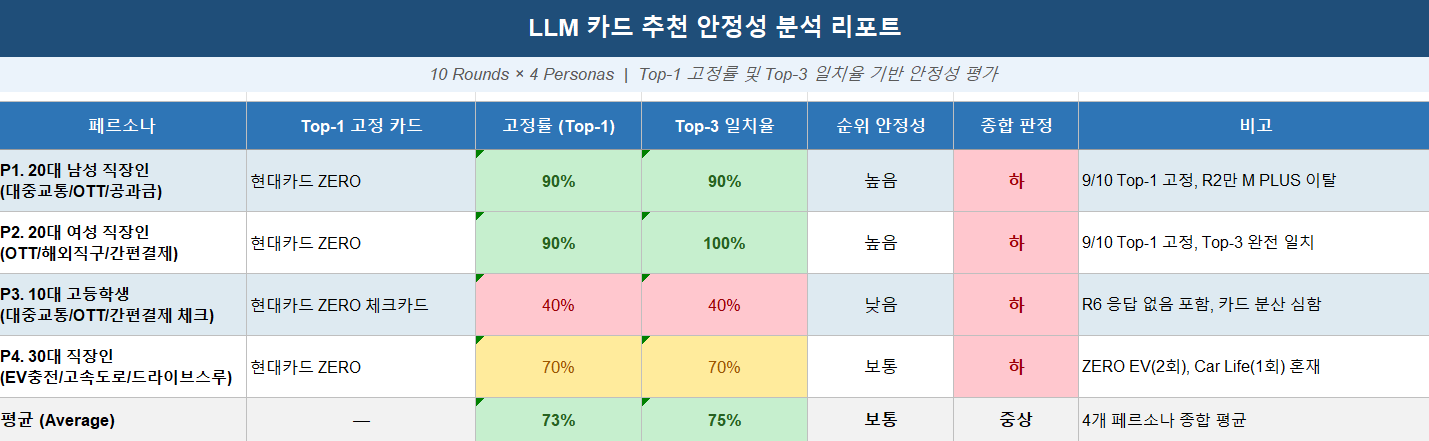

## 일반 RAG 결과

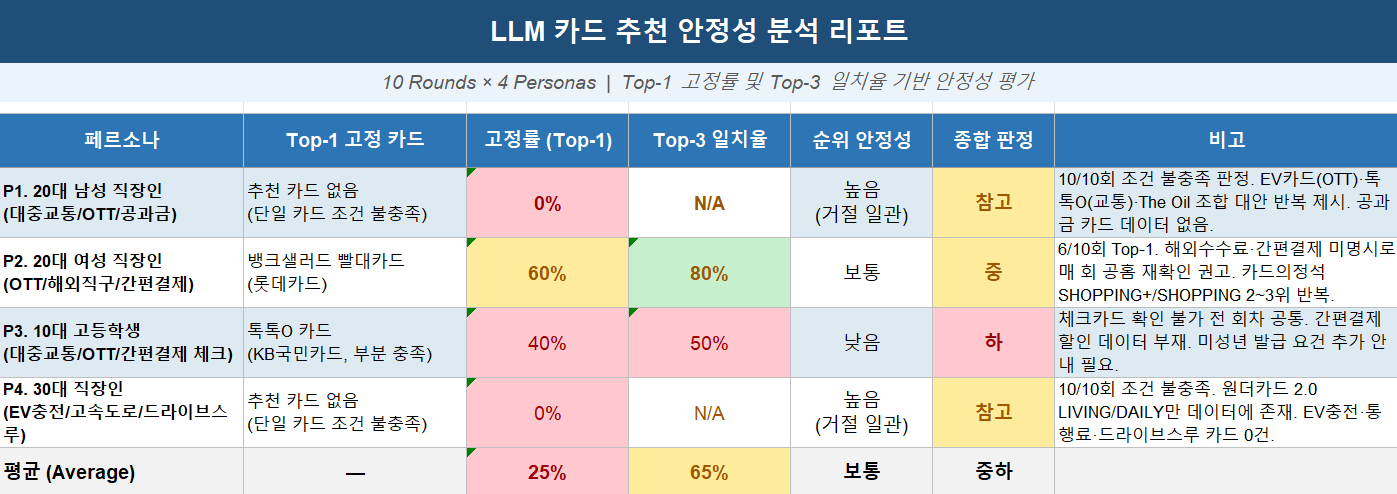


## 고도화 RAG 결과

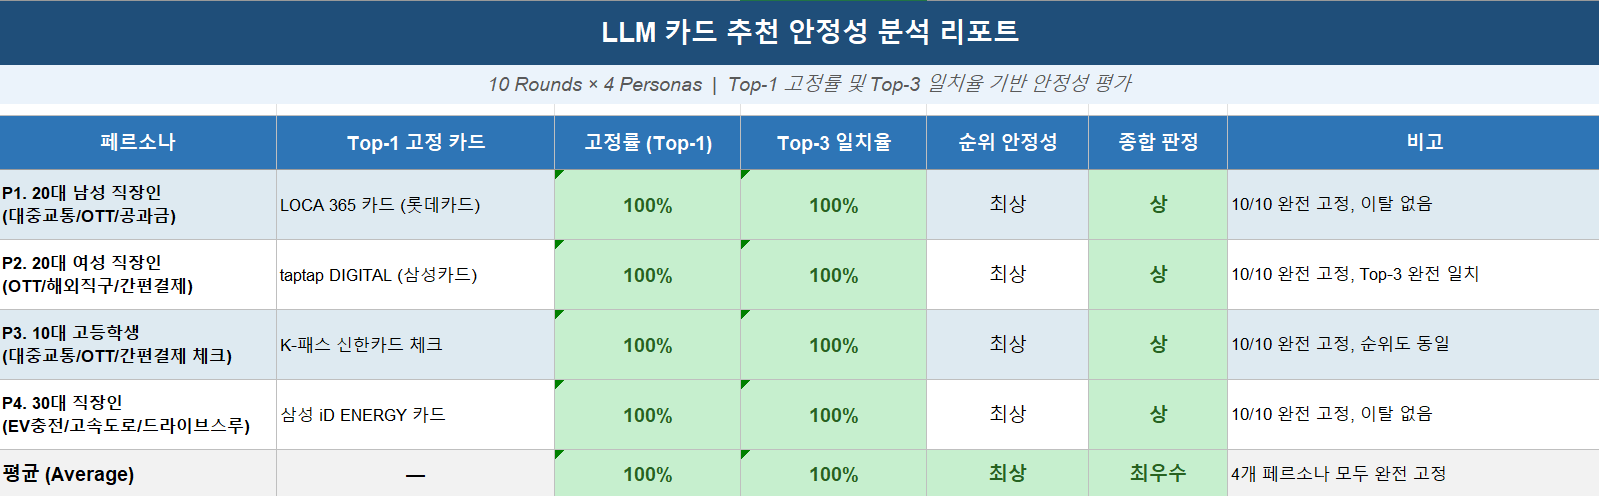